# 🐧 The Evolution of Puffin's Population Regarding Climate Change

Welcome to the main Jupyter Notebook of our _Python project for Data Science_ ! 
Studying at the engineering school ENSAE, Institut Polytechnique de Paris, this project is part of the 2nd year course, under the supervision of Lino Galiana (Insee) and Romain Avouac (Insee). 

We share a passion for a clumsy but reaaaally cute seabird that is very common in Iceland : **the Atlantic puffin**. Unluckily, its demographic trend is downward. Well, it's not all by chance. Various high-qualited scientific studies have been carried out over the years to demonstrate the challenges facing this seabird species. Its biggest enemy to date is **climate change**, which is affecting its feeding (fish), reproduction and nesting. 

With this notebook, we set out to (re)demonstrate the causal link between global warming and the decline in the Atlantic puffin population. **The aim at the end of this page is to establish medium-term predictions for the evolution of this species, taking into account the different climate scenarios envisaged. Graphical visualization tools will support our modeling results.** 

Are you ready to see the disastrous consequences of climate change on such adorable birds? Let's get started! 
🐧🐧🐧🐧🐧🐧

## 0.1 : Setting up the work environment 

- data access through the cloud MinIO Client (files are in the folder 'diffusion')
- required packages 
- organizated environment 

In [10]:
import pandas as pd
import s3fs
import os

# Geographical vizualisation packages
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point
import matplotlib
import contextily as ctx


# Creation of two folders to centralize data and results
data_dir = "./data"  
os.makedirs(data_dir, exist_ok=True) 
results_dir = "./results"
os.makedirs(results_dir, exist_ok=True)




# Access information to the cloud MinIO Client (Eve's bucket)
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "esam"
print(fs.ls(MY_BUCKET))

['esam/diffusion']


## xx : Map visualization of Atlantic puffin distribution worldwide 

The Atlantic puffin is a migratory bird of the North Atlantic and Arctic polar zones. BirdLife International's data enable us to visualize the presence of these birds across the globe. 

_Nota bene : Having encountered difficulties working with files directly in S3 streams (shapefile, .nc, etc.), it is preferable to download files directly from the MinIO Client locally, to ensure optimal operation of the pandas and geopandas ecosystems, which is what the following program does._ 

In [23]:
#Reading of shapefile file of worldwide puffin's distribution from the bucket 
local_folder = "./data"
local_shapefile_subfolder = os.path.join(local_folder, "local_shapefile_files")
os.makedirs(local_shapefile_subfolder, exist_ok=True)



shapefile_elements = ["F_arctica.shp", "F_arctica.shx", "F_arctica.dbf"]

for element in shapefile_elements:
    remote_path = f"{MY_BUCKET}/diffusion/puffin_data/{element}"
    local_path = os.path.join(local_shapefile_subfolder, element)
    with fs.open(remote_path, "rb") as remote_file:
        with open(local_path, "wb") as local_file:
            local_file.write(remote_file.read())
    
        # This function allows you to download files locally from the cloud to create a map with geopandas. 
        # These files appear in your newly created .data/local_shapefile_files folder. 



# Lecture and overview of the main shapefile file 
local_shapefile_path = os.path.join(local_shapefile_subfolder, "F_arctica.shp")
gdf = gpd.read_file(local_shapefile_path)
print(gdf.head())


gdf = gdf.set_crs(epsg=32633)  # Remplacez 32633 par le CRS de vos données

# Checking the geographic coordinate system
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs(epsg=4326)
    print("Système de projection (CRS) :", gdf.crs)
    #After transformation to EPSG:4326: 
    # Coordinates will be in latitudes and longitudes, ready to be used in a web application or integrated with other global data.

# Conversion des géométries 3D en 2D
def convert_to_2d(geom):
    if geom is None:
        return None
    if geom.has_z:
        if isinstance(geom, Polygon):
            return Polygon([[x, y] for x, y, z in geom.exterior.coords])
        elif isinstance(geom, LineString):
            return LineString([[x, y] for x, y, z in geom.coords])
        elif isinstance(geom, Point):
            return Point(geom.x, geom.y)
    return geom

gdf["geometry"] = gdf["geometry"].apply(convert_to_2d)
print("End of conversion to 2D.")

# Vérification des géométries invalides
gdf = gdf[gdf.is_valid]
print("Number of validated geometries :", len(gdf))


print(gdf.geom_type.value_counts())  # Affiche les types de géométries dans vos données


      sisid            sci_name  presence  origin  seasonal  \
0  22694927  Fratercula arctica         1       1         3   
1  22694927  Fratercula arctica         1       1         2   
2  22694927  Fratercula arctica         1       1         2   

                                              source  \
0  Seabird Tracking Database, Gaston & Jones, 199...   
1  National Geographic Society, 1999; Cramp, 1997...   
2      Gaston & Jones, 1998; Poole & Gill, 1992-2002   

                                            compiler  data_sens sens_comm  \
0  Colin Michel, Rob Martin; Joe Taylor (BirdLife...          0      None   
1                Rob Martin (BirdLife International)          0      None   
2    Rob Martin; Joe Taylor (BirdLife International)          0      None   

      dist_comm tax_comm  generalisd  \
0          None     None           0   
1          None     None           0   
2  At-sea range     None           0   

                                            citation

In [24]:
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point

# Lecture du GeoDataFrame
gdf = gpd.read_file(local_shapefile_path)

# Définir le CRS initial (par exemple EPSG:32633, UTM zone 33N)
gdf = gdf.set_crs(epsg=32633)  # Remplacez 32633 par le CRS d'origine des données

# Reprojection en EPSG:4326
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs(epsg=4326)

# Conversion des MultiPolygon en Points (centroids)
gdf["geometry"] = gdf["geometry"].centroid

# Vérifiez les géométries converties
print(gdf.geometry.head())

# Création de la carte Folium
m = folium.Map(location=[55, -30], zoom_start=3, tiles="CartoDB Positron")

# Ajout d'un cluster pour les points
marker_cluster = MarkerCluster().add_to(m)

# Ajout des données à la carte
for idx, row in gdf.iterrows():
    if row.geometry.geom_type == "Point":  # Vérifiez que la géométrie est un Point
        coords = [row.geometry.y, row.geometry.x]  # [Latitude, Longitude]
        folium.Marker(
            location=coords,
            popup=folium.Popup(f"<b>Macareux moine ID:</b> {idx}", max_width=300),
            icon=folium.Icon(color="blue", icon="info-sign")
        ).add_to(marker_cluster)

# Afficher la carte directement dans le Notebook
from IPython.display import display
display(m)


0    POINT (10.51113 0.00053)
1    POINT (10.51091 0.00061)
2    POINT (10.51088 0.00059)
Name: geometry, dtype: geometry


/tmp/ipykernel_85902/2754797656.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["geometry"] = gdf["geometry"].centroid


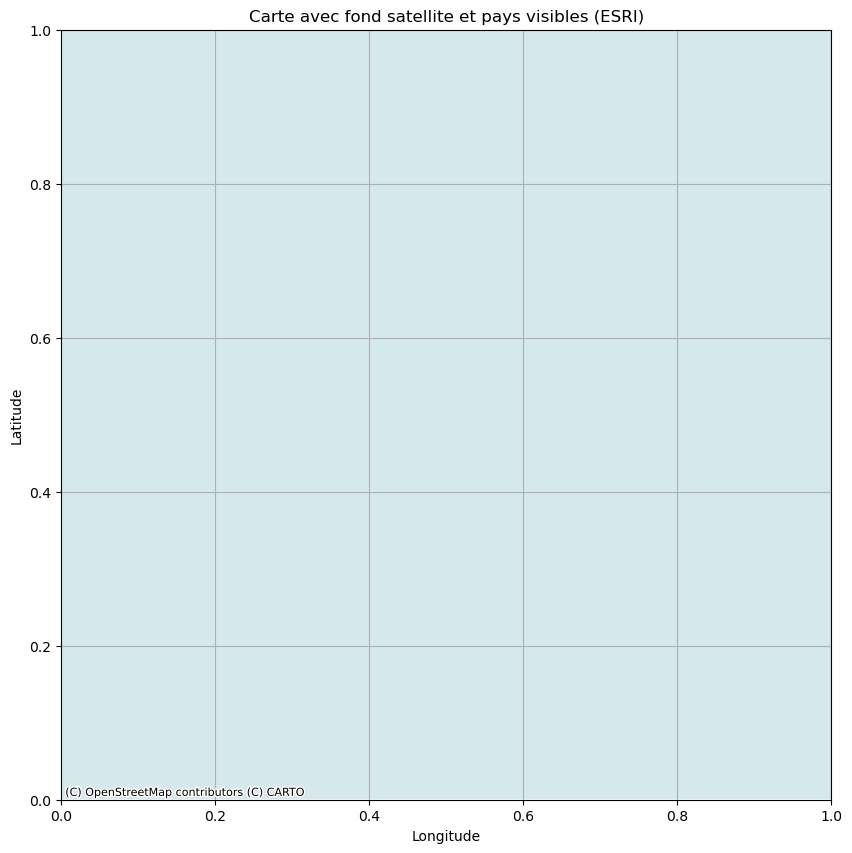

In [17]:
# Affichage de la carte et ajout du fond de carte
fig, ax = plt.subplots(1, 1, figsize=(12, 10))



ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Voyager)

# Ajout des données du GeoDataFrame
gdf.plot(ax=ax, edgecolor="red", cmap="Set2", alpha=0.6)

# Personnalisation
ax.set_title("Carte avec fond satellite et pays visibles (ESRI)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid()


# Sauvegarder la carte dans un fichier PNG
plt.savefig("./results/F_arctica.png")

In [ ]:
# Utiliser un backend compatible
matplotlib.use('Agg')

# Chemin vers le fichier .shp
fichier_shp = "/Users/audrey/projet_python_2024_ENSAE/F_arctica"


# Lecture du fichier shapefile
gdf = gpd.read_file(fichier_shp)

# Affichage des premières lignes du GeoDataFrame
print(gdf.head())

# Transformation en EPSG:4326 si nécessaire
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs(epsg=4326)
print("Système de projection (CRS) :", gdf.crs)

# Conversion des géométries 3D en 2D
def convert_to_2d(geom):
    if geom is None:
        return None
    if geom.has_z:
        if isinstance(geom, Polygon):
            return Polygon([[x, y] for x, y, z in geom.exterior.coords])
        elif isinstance(geom, LineString):
            return LineString([[x, y] for x, y, z in geom.coords])
        elif isinstance(geom, Point):
            return Point(geom.x, geom.y)
    return geom

gdf["geometry"] = gdf["geometry"].apply(convert_to_2d)
print("Conversion en 2D terminée.")

# Vérification des géométries invalides
gdf = gdf[gdf.is_valid]
print("Nombre de géométries valides :", len(gdf))

'''
# Affichage de la carte et sauvegarde dans un fichier
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf.plot(ax=ax, edgecolor='black', cmap='Set2')
ax.set_title("Carte du Shapefile")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid()

# Sauvegarder la carte dans un fichier PNG
plt.savefig("/home/onyxia/work/projet_python_2024_ENSAE/carte_shapefile2.png")
print("Carte sauvegardée sous 'carte_shapefile2.png'")
'''

# Affichage de la carte et ajout du fond de carte
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plotting du GeoDataFrame
gdf.plot(ax=ax, edgecolor='black', cmap='Set2')

# Ajout d'un fond de carte via contextily (ici OpenStreetMap)
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Personnalisation du graphique
ax.set_title("Carte du Shapefile avec fond OpenStreetMap")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid()

# Sauvegarder la carte dans un fichier PNG
plt.savefig("/Users/audrey/projet_python_2024_ENSAE/F_arctica.png")
print("Carte sauvegardée sous 'carte_shapefile2_avec_fond.png'")

import geopandas as gpd

# Charger le fichier shapefile
fichier_shp = "/Users/audrey/projet_python_2024_ENSAE/F_arctica"
gdf = gpd.read_file(fichier_shp)

# Afficher les colonnes disponibles
print("Colonnes disponibles dans le fichier :")
print(gdf.columns)

# Afficher un échantillon des données pour voir les valeurs
print("\nExtrait des données :")
print(gdf)

# Vérifier si certaines colonnes contiennent des mots-clés pertinents
keywords = ['nombre', 'count', 'fratercula', 'arctica', 'date', 'zone', 'area']
print("\nColonnes contenant des mots-clés pertinents :")
for col in gdf.columns:
    for keyword in keywords:
        if keyword.lower() in col.lower():
            print(f"- {col}")

import geopandas as gpd

# Charger le fichier shapefile
fichier_shp = "/Users/audrey/projet_python_2024_ENSAE/F_arctica"
gdf = gpd.read_file(fichier_shp)

# Afficher les premières lignes pour vérifier le contenu
print("Premières lignes du fichier shapefile :")
print(gdf.head())

# Extraire uniquement les données attributaires (sans la géométrie)
df_attributs = gdf.drop(columns='geometry')

# Sauvegarder les données attributaires au format CSV
fichier_csv = "/Users/audrey/projet_python_2024_ENSAE/F_arctica_attributs.csv"
df_attributs.to_csv(fichier_csv, index=False)

print(f"Les attributs ont été exportés avec succès dans le fichier : {fichier_csv}")